<a href="https://colab.research.google.com/github/pablex72/tensorflow-practices/blob/main/Forecasting_the_stock_market_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using a machine learning model, this tutorial will predict a stock’s future value in real time with high accuracy on a stock exchange

To predict if the stock price will rise or fall tomorrow, we will use Google stock data as a time series. The data will be obtained from the Yfinance API.

**IMPORT**

In [3]:
!pip install yfinance
import yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.8 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Using the Yfinance API, download Google stock data



In [8]:
data = yfinance.download("GOOGL", start = "2019-01-01", interval = '1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,51.360001,53.039501,51.264000,52.734001,52.734001,31868000
2019-01-03,52.533501,53.313000,51.118500,51.273499,51.273499,41960000
2019-01-04,52.127998,54.000000,51.842999,53.903500,53.903500,46022000
2019-01-07,54.048500,54.134998,53.132000,53.796001,53.796001,47446000
2019-01-08,54.299999,54.667500,53.417500,54.268501,54.268501,35414000
...,...,...,...,...,...,...
2023-03-09,94.050003,95.529999,91.900002,92.320000,92.320000,28813500
2023-03-10,92.169998,92.790001,90.400002,90.629997,90.629997,35927000
2023-03-13,90.089996,92.570000,89.419998,91.110001,91.110001,37335600


In addition to checking the dataset details such as the data types of the features, we also need to check if there are any null values.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1058 entries, 2019-01-02 to 2023-03-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1058 non-null   float64
 1   High       1058 non-null   float64
 2   Low        1058 non-null   float64
 3   Close      1058 non-null   float64
 4   Adj Close  1058 non-null   float64
 5   Volume     1058 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.9 KB


In the next step, we will check for non-numeric values in the ‘Close’ feature and change them to Nan. Check for non-numeric values in the dataset as well.

In [10]:
data["Close"]

Date
2019-01-02    52.734001
2019-01-03    51.273499
2019-01-04    53.903500
2019-01-07    53.796001
2019-01-08    54.268501
                ...    
2023-03-09    92.320000
2023-03-10    90.629997
2023-03-13    91.110001
2023-03-14    93.970001
2023-03-15    95.879997
Name: Close, Length: 1058, dtype: float64

In [15]:
# check for non-numeric values in the ‘Close’ feature and change them to Nan
data["Close"] = pd.to_numeric(data.Close, errors = 'coerce')
# Check for non-numeric values in the dataset as well.
print(data.isnull().sum().sum()) # it is 0
print(data.duplicated().any()) # it is false
# There are no Nan values associated with the ‘Close’ feature

0
False


In the next step, we will plot the close and check the stock’s growth based on the time.

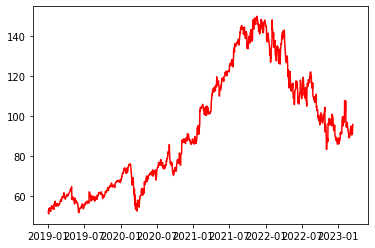

In [16]:
plt.plot(data.index, data['Close'], color='red', label = 'Close column')
plt.show()

**Processing of data**

Due to the limited number of features we are going to use in this tutorial, a new dataframe will be created, dataV1, and only contain the Close feature.



In [21]:
dataV1 = data.iloc[:,3:4]
print(dataV1)
dataV1 = dataV1.values
print(dataV1)

                Close
Date                 
2019-01-02  52.734001
2019-01-03  51.273499
2019-01-04  53.903500
2019-01-07  53.796001
2019-01-08  54.268501
...               ...
2023-03-09  92.320000
2023-03-10  90.629997
2023-03-13  91.110001
2023-03-14  93.970001
2023-03-15  95.879997

[1058 rows x 1 columns]
[[52.73400116]
 [51.27349854]
 [53.9034996 ]
 ...
 [91.11000061]
 [93.97000122]
 [95.87999725]]


To normalize our data, import MinMaxScaler from sklearn library. It does this by transforming a feature by scaling it to a given range in this case just the ‘Close’ feature.

In [22]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler(feature_range = (0,1))
dataV1 = Scaler.fit_transform(dataV1)

In [23]:
feature_length = 100

**Funcion Auxiliar**

Our data has to be divided into X and Y variables before we can build the model. To do so, we will write a function called Create_Features_and_Targets.



In [31]:
# Function to create x and y data
def Create_Features_and_Targets(data, feature_length):
  X = list()
  Y = list()
  for i in range(len(data) - feature_length - 1):
    X.append(data[i:(i + feature_length), 0])
    Y.append(data[i + feature_length, 0])
  X = np.array(X)
  Y = np.array(Y)
  return X, Y
X_train, y_train = Create_Features_and_Targets(dataV1, feature_length)

*****As LSTM takes 3 dimensional data as input, data should be made 3 dimensional.*

In [32]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))
X_train.shape, y_train.shape

((957, 100, 1), (957,))

**Model creation**

In [33]:
# Create the model by importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

Adam will be used as an optimizer for the LSTM model we will create which consists of two LSTM layers, two dropout layers, and one dense layer.

In [35]:
# LSTMs are recurrent neural networks (RNNs). In simple terms, LSTMs work by allowing the network to remember 
# the context of the model while forgetting the irrelevant information.
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.3),
    LSTM(100, return_sequences= False),
    Dropout(0.3),

    Dense(1),
])
model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 100)          40800     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


Using the model.fit function, we can now train the model. Our model will be trained using a batch_size of 12 under 100 epochs.

In [36]:
history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 1,
)

Epoch 1/100
80/80 [==============================] - 15s 120ms/step - loss: 0.0186
Epoch 2/100
80/80 [==============================] - 10s 131ms/step - loss: 0.0044
Epoch 3/100
80/80 [==============================] - 11s 132ms/step - loss: 0.0047
Epoch 4/100
80/80 [==============================] - 11s 134ms/step - loss: 0.0039
Epoch 5/100
80/80 [==============================] - 11s 133ms/step - loss: 0.0040
Epoch 6/100
80/80 [==============================] - 11s 133ms/step - loss: 0.0038
Epoch 7/100
80/80 [==============================] - 11s 134ms/step - loss: 0.0041
Epoch 8/100
80/80 [==============================] - 10s 122ms/step - loss: 0.0036
Epoch 9/100
80/80 [==============================] - 11s 136ms/step - loss: 0.0034
Epoch 10/100
80/80 [==============================] - 11s 135ms/step - loss: 0.0028
Epoch 11/100
80/80 [==============================] - 11s 137ms/step - loss: 0.0032
Epoch 12/100
80/80 [==============================] - 11s 141ms/step - loss: 0.0032
E

It’s time to test the model now that we have successfully trained it. For testing the model, the whole data set will be used, and the predicted data will be plotted against the actual data.

**Predicting and testing**

To run the tests, you will need to collect data from two datasets. The ‘Close’ feature should be used to create two variables, one for plotting real data, y_real, and one for making predictions, x_test. Our goal is to create the x_test variable by getting all the values from the ‘Close’ feature, scaling the data with Scaler.transform and transforming the shape to a 3D shape. From the ‘Close’ feature, we can get all values starting from the 101st value to create the y_real variable.

In [38]:
testData = data.iloc[:,3:4] # get close feature
y_real = testData.iloc[feature_length + 1 :, 0:].values #Actual values
x_test = testData.iloc[:,0:].values # data to test
# normalizing the Data using Scaler.transform function
x_test = Scaler.transform(x_test)
x_test, y_test = Create_Features_and_Targets(x_test, feature_length)
#Making data 3d
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

**Making predictions**

In [39]:
# Now let’s plot the data after running the prediction test

y_pred = model.predict(x_test)
predicted_price = Scaler.inverse_transform(y_pred)

30/30 [==============================] - 3s 55ms/step


Comparison of predicted and actual stock prices

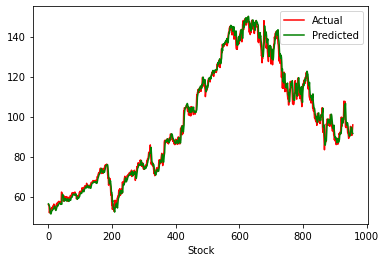

In [40]:
plt.plot(y_real, color = 'red', label = 'Actual')
plt.plot(predicted_price, color = 'green', label = 'Predicted')
plt.xlabel('Time')
plt.xlabel('Stock')
plt.legend()
plt.show()